Here I demonstrate how semantic entropy probes. Briefly, I download TriviaQA dataset and mistral 7b model. Then I made datasets with greedy decoded answer and extracted hidden activations. Also I calculate semantic entropy for each example. Then I tran linear probes for different layers and setups (first generated token and second last token).  

**More about structure of notebook**
0) Imports, parameters. Pay attention that I use functions from external github.com/jlko/semantic_uncertainty repo. You can do as I did or just paste that function in some cell inside notebook.
1) Not download but use streaming mode for subsample obtaining of trivia QA. 
2) Split onto 3 part (train, val, test)
3) Load model mistarl 7b and roberta for entailment and calculation of SE
4) Use greedy decoding for getting answer of model and obtaining activation from choosen layers and positions. I did as follows. First: generate answer in greedy manner, then forward result sequence through model with output_hidden_state flag toggled on. 
5) Generate several generations and calculate semantic entropy using functions from external repo. 
6) Binarization of labels and obtaining weights for each sample. 
7) Save dataset to disk
8) Train linear probes 
9) Metrics calculation and visualization
10) Save models
11) Inference in near real time scenario

### Setup

In [1]:
# Imports
from datasets import load_dataset
from itertools import islice
import random
from copy import deepcopy
from typing import List, Dict, Any

import numpy as np
import torch
import torch.nn.functional as F

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

import json

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import matplotlib.pyplot as plt

import os
import json
import pickle
from pathlib import Path

torch: 2.9.1+cu128
cuda available: True
gpu: NVIDIA GeForce RTX 3060


Here I import EntailmentRoBERTa, get_semantic_ids, logsumexp_by_id, predictive_entropy_rao from github.com/jlko/semantic_uncertainty

I made git subtree into external/ subdirectory of project. You can just copy functions from original repo and paste it here for simplification.

Also deberta doesn't work for me and I use RoBERTa (I add class to original repository with the same method for entailment task)

In [2]:
!ls ../external/semantic_uncertainty/

environment_export.yaml  LICENSE    README.md
environment.yaml	 notebooks  semantic_uncertainty


In [3]:
# Import custom functions from external repository
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT / "external" / "semantic_uncertainty"))
sys.path.insert(0, str(PROJECT_ROOT / "external" / "semantic_uncertainty" / "semantic_uncertainty"))
sys.path.insert(0, str(PROJECT_ROOT / "external" / "semantic_uncertainty" / "semantic_uncertainty" / "uncertainty"))


import semantic_uncertainty
import uncertainty

print("uncertainty:", getattr(uncertainty, "__file__", None))

from semantic_uncertainty.uncertainty.uncertainty_measures.semantic_entropy import (
    EntailmentRoBERTa,
    get_semantic_ids,
    logsumexp_by_id,
    predictive_entropy_rao,
)
print("semantic_entropy imports OK")

uncertainty: /home/zazamrykh/projects/internal_probing/external/semantic_uncertainty/semantic_uncertainty/uncertainty/__init__.py
semantic_entropy imports OK


In [4]:
# Params
SEED = 42
random.seed(SEED)
CREATE_DATASETS = True  # if False skips first 7 steps and just trains probes

# Dataset
n_samples = 3500
n_train = 2500
n_val = 500
n_test = 500
assert n_samples == n_train + n_val + n_test

shuffle_buffer = 10_000
split_name = "validation"

# Model 
MODEL = "../models/mistral-7b-instruct" # "mistralai/Mistral-7B-Instruct-v0.1" # choose model name instead of path to local folder with model
ENTAILMENT_MODEL = '../models/roberta-large-mnli'

# Step 4 parameters
# ----- generation -----
max_new_tokens_greedy = 64
greedy_do_sample = False  # greedy
use_chat_template = True 
SYSTEM_PROMPT = "Answer as briefly as possible. Prefer one or a few words. Do not add explanations."  # Probably makes quality worse

VERBOSE_EVERY = 100

# ----- activations / SEP -----
layers_to_capture = [0, 4, 8, 12, 16, 20, 24, 28, 31] 
# positions corresponding to generated part
# 0 = TBG (first generated token)
# -2 = SLT (second-to-last generated token).
positions_generated = [0, -2]

# Step 5 semantic entropy calculation
SE_SAMPLING_N = 10
max_new_tokens_sampling = 64

# Save datasets path
SAVE_DIR = Path("../data/sep_demo")


# Probe training params
PROBE_MAX_ITER = 500
PROBE_C = 1.0
PROBE_SOLVER = "lbfgs"
USE_SAMPLE_WEIGHTS = False
K_FOLDS = 5

# Where to save probes
OUTPUT_LINEAR_PROBES = "../models/probes/sep_demo"

### 1. Loading data Trivia QA

In [5]:
ds_stream = load_dataset(
    "mandarjoshi/trivia_qa",
    "rc.nocontext",
    split=split_name,
    streaming=True,
)

# Shuffle with buffer (without full load of dataset)
ds_stream = ds_stream.shuffle(seed=SEED, buffer_size=shuffle_buffer)

samples = list(islice(ds_stream, n_samples))

print(len(samples), samples[0].keys())

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

3500 dict_keys(['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'])


In [6]:
def simplify_triviaqa_example(ex):
    q = ex["question"]

    # GT-answers
    ans = ex.get("answer", {})
    gt = ans.get("normalized_aliases") or []
    if not gt:
        nv = ans.get("normalized_value")
        if nv:
            gt = [nv]

    return {
        "question": q,
        "gt_answers": gt,
        "answer_raw": ans,
    }

samples_simple = [simplify_triviaqa_example(ex) for ex in samples]
print(f'Sample: {samples_simple[0]}')

Sample: {'question': 'Thanatology is the scientific study of what?', 'gt_answers': ['deceased', 'somatic death', 'predecease', 'dy d', 'premature death', 'deaths', 'decedent', 'indicative of death', 'articulus mortis', 'mortals', 'human death', 'plant death', 'deathly', 'devitalized', 'passing away', 'articulo mortis', 'died', 'signs of death', 'dying', 'deadness', 'biological death', 'dead', 'predeceased', 'death signs', 'mortally', 'technically dead', 'death science', 'fatally wounded', 'stages of death', 'death and dying', 'deceasing', 'death', 'deceases', 'death medicine', 'exitus letalis', 'physical death', 'exitus', 'decease'], 'answer_raw': {'aliases': ['Devitalized', 'Predeceased', 'Death', 'Deathly', 'Predecease', 'Dying', "Dy'd", 'Somatic death', 'Dead', 'Exitus', 'Deceasing', 'Biological death', 'Death and Dying', 'Decedent', 'Signs of death', 'Death (science)', 'Plant death', 'Mortals', 'Mortally', 'Articulus mortis', 'Physical death', 'Died', 'Death (medicine)', 'Passing a

### 2. Shuffle data and split into train-val-test

In [7]:
assert n_train + n_val + n_test <= len(samples_simple)

rng = random.Random(SEED)

data = samples_simple.copy()
rng.shuffle(data)

train_data = data[:n_train]
val_data   = data[n_train:n_train + n_val]
test_data  = data[n_train + n_val:n_train + n_val + n_test]

print(f'Length train: {len(train_data)}, length val: {len(val_data)}, length test: {len(test_data)}')

Length train: 2500, length val: 500, length test: 500


### 3. Load models

In [8]:
# 8-bit quantization
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    device_map="auto",
    quantization_config=quant_config,
)

model.eval()
print("Loaded (8-bit) from:", MODEL)

# remove warnings
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded (8-bit) from: ../models/mistral-7b-instruct


In [9]:
ent_model = EntailmentRoBERTa(model=ENTAILMENT_MODEL)

Some weights of the model checkpoint at ../models/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 4. Greedy answers generations and activations aquistision

In [10]:
def build_prompt_ids(tokenizer, question: str, system_prompt: str | None = None):
    if use_chat_template and hasattr(tokenizer, "apply_chat_template"):
        messages = []
        if system_prompt and system_prompt.strip():
            messages.append({"role": "system", "content": system_prompt.strip()})
        messages.append({"role": "user", "content": question})

        prompt_ids = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
        )
    else:
        # Fallback
        print('Warning: fall into fallback') # comment this string if this is expected fallback
        if system_prompt and system_prompt.strip():
            text = system_prompt.strip() + "\n\n" + question
        else:
            text = question
        prompt_ids = tokenizer(text, return_tensors="pt").input_ids

    return prompt_ids

def greedy_generate_text(model, tokenizer, question: str, max_new_tokens: int, system_prompt=None):
    prompt_ids = build_prompt_ids(tokenizer, question, system_prompt=system_prompt).to(model.device)
    attention_mask = torch.ones_like(prompt_ids)

    with torch.inference_mode():
        out = model.generate(
            prompt_ids,
            attention_mask=attention_mask,
            do_sample=False,               # greedy
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
        )
    full_ids = out.sequences[0]
    gen_ids = full_ids[prompt_ids.shape[1]:]
    gen_text = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
    return gen_text, prompt_ids, gen_ids

def is_correct_triviaqa(generated_text: str, gt_aliases: list[str]):
    pred = generated_text.casefold()
    aliases = [a.casefold() for a in gt_aliases]

    return any(a in pred for a in aliases if a)  # substring match


In [11]:
def extract_activations_for_probe(
    model,
    tokenizer,
    prompt_ids: torch.Tensor,  # shape (1, prompt_len)
    gen_ids: torch.Tensor,     # shape (gen_len,)
    layers: list[int],
    positions_gen: list[int],
):
    """
    Returns activations in format:
    {
      "positions": positions_gen,
      "layers": layers,
      "acts": {pos: {layer: tensor(hidden_dim)}}  # Tensors on cpu
    }
    """
    # build full sequence (concat) (1, prompt+gen)
    full_ids = torch.cat([prompt_ids[0], gen_ids], dim=0).unsqueeze(0).to(model.device)
    attention_mask = torch.ones_like(full_ids)

    with torch.inference_mode():
        out = model(
            input_ids=full_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
        )

    # hidden_states: tuple of len (num_layers+1), where [0] = embedding output
    hidden_states = out.hidden_states

    prompt_len = prompt_ids.shape[1]
    gen_len = gen_ids.shape[0]

    acts = {}
    for pos in positions_gen:
        # pos is in generated part coordinates
        idx = pos if pos >= 0 else gen_len + pos  # for example -2 -> gen_len-2 (to work with SLT setup)
        if idx < 0 or idx >= gen_len:
            raise ValueError(f"Position {pos} out of range for generated length {gen_len}")

        full_pos = prompt_len + idx  # absolute pos

        acts[pos] = {}
        for layer in layers:
            # +1 из-за embedding layer на hidden_states[0]
            hs = hidden_states[layer + 1][0, full_pos, :].detach().to("cpu")
            acts[pos][layer] = hs

    return {"positions": positions_gen, "layers": layers, "acts": acts, "gen_len": gen_len}

In [12]:
def process_one_example_greedy_with_acts(ex, model, tokenizer, system_prompt=None):
    q = ex["question"]
    gt = ex["gt_answers"]

    greedy_text, prompt_ids, gen_ids = greedy_generate_text(
        model, tokenizer, q, max_new_tokens=max_new_tokens_greedy, system_prompt=system_prompt
    )

    correct = is_correct_triviaqa(greedy_text, gt)

    activations = extract_activations_for_probe(
        model=model,
        tokenizer=tokenizer,
        prompt_ids=prompt_ids,
        gen_ids=gen_ids,
        layers=layers_to_capture,
        positions_gen=positions_generated,
    )

    return {
        "question": q,
        "gt_answers": gt,
        "greedy_answer": greedy_text,
        "is_correct": bool(correct),
        "activations": activations, 
    }

In [13]:
sample = train_data[0]
print(f'Sample from train has keys: {sample.keys()}. \nThe question is: "{sample['question']}", \nfirst 3 ground truth answers are: {sample['gt_answers'][:5]}\n')

result = process_one_example_greedy_with_acts(sample, model, tokenizer, SYSTEM_PROMPT)
print(f'Result of process_one_example_greedy_with_acts has keys: {result.keys()}')
print(f'Greedy answer is: {result['greedy_answer']}')
print(f'Correctness label: {result['is_correct']}')
print(f'Hidden dim of one hidden state is: {len(result['activations']['acts'][0][31])}')

Sample from train has keys: dict_keys(['question', 'gt_answers', 'answer_raw']). 
The question is: "Which actor does the interviewing in 'Interview with a Vampire'?", 
first 3 ground truth answers are: ['christian slater']

Result of process_one_example_greedy_with_acts has keys: dict_keys(['question', 'gt_answers', 'greedy_answer', 'is_correct', 'activations'])
Greedy answer is: Brad Pitt
Correctness label: False
Hidden dim of one hidden state is: 4096


In [14]:
def enrich_dataset_with_greedy_and_activations(
    data: List[Dict[str, Any]],
    model,
    tokenizer,
    system_prompt: str,
    inplace: bool = False,
    verbose_every: int = 100,
):
    """
    Add fields:
      - greedy_answer: str
      - is_correct: bool
      - activations: dict (see process_one_example_greedy_with_acts function)
    """
    out = data if inplace else deepcopy(data)

    for i, ex in enumerate(out):
        res = process_one_example_greedy_with_acts(ex, model, tokenizer, system_prompt)

        ex["greedy_answer"] = res["greedy_answer"]
        ex["is_correct"] = res["is_correct"]
        ex["activations"] = res["activations"]

        if verbose_every and (i + 1) % verbose_every == 0:
            print(f"[greedy+acts] processed {i+1}/{len(out)}")

    return out

In [15]:
if CREATE_DATASETS:
    # Execution
    train_greedy = enrich_dataset_with_greedy_and_activations(
        train_data, model, tokenizer, SYSTEM_PROMPT, inplace=True, verbose_every=VERBOSE_EVERY
    )

    val_greedy = enrich_dataset_with_greedy_and_activations(
        val_data, model, tokenizer, SYSTEM_PROMPT, inplace=True, verbose_every=VERBOSE_EVERY
    )

    test_greedy = enrich_dataset_with_greedy_and_activations(
        test_data, model, tokenizer, SYSTEM_PROMPT, inplace=True, verbose_every=VERBOSE_EVERY
    )

[greedy+acts] processed 100/2500
[greedy+acts] processed 200/2500
[greedy+acts] processed 300/2500
[greedy+acts] processed 400/2500
[greedy+acts] processed 500/2500
[greedy+acts] processed 600/2500
[greedy+acts] processed 700/2500
[greedy+acts] processed 800/2500
[greedy+acts] processed 900/2500
[greedy+acts] processed 1000/2500
[greedy+acts] processed 1100/2500
[greedy+acts] processed 1200/2500
[greedy+acts] processed 1300/2500
[greedy+acts] processed 1400/2500
[greedy+acts] processed 1500/2500
[greedy+acts] processed 1600/2500
[greedy+acts] processed 1700/2500
[greedy+acts] processed 1800/2500
[greedy+acts] processed 1900/2500
[greedy+acts] processed 2000/2500
[greedy+acts] processed 2100/2500
[greedy+acts] processed 2200/2500
[greedy+acts] processed 2300/2500
[greedy+acts] processed 2400/2500
[greedy+acts] processed 2500/2500
[greedy+acts] processed 100/500
[greedy+acts] processed 200/500
[greedy+acts] processed 300/500
[greedy+acts] processed 400/500
[greedy+acts] processed 500/500

In [16]:
if CREATE_DATASETS:
    train_greedy[1].keys(), train_greedy[1]['question'], train_greedy[1]['gt_answers'][0], train_greedy[1]['greedy_answer'], train_greedy[1]['is_correct']

### 5. Semantic entropy calculation

Continue make dataset. Current step is apply semantic entropy calculation. Here I will use functions from semantc_unsertainty/uncertainty module from github.com/jlko/semantic_uncertainty repository.

In [17]:
def generate_one(model, tokenizer, question, max_new_tokens=64, temperature=1.0, top_p=0.95, system_prompt=None):
    prompt_ids = build_prompt_ids(tokenizer, question, system_prompt=system_prompt).to(model.device)
    attention_mask = torch.ones_like(prompt_ids)

    out = model.generate(
        prompt_ids,
        max_new_tokens=max_new_tokens,
        attention_mask=attention_mask,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        return_dict_in_generate=True,
        output_logits=True,   # important
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    prompt_len = prompt_ids.shape[1]
    seq = out.sequences[0]
    gen_tokens = seq[prompt_len:]  # (T,)
    # logits: tuple length T, each (batch=1, vocab)
    logits_steps = out.logits

    # log p for every generated token
    token_logprobs = []
    for t, step_logits in enumerate(logits_steps):
        tok = gen_tokens[t].item()
        lp = F.log_softmax(step_logits[0], dim=-1)[tok]
        token_logprobs.append(lp)

    # average log likelyhood for answer
    avg_token_loglik = torch.stack(token_logprobs).mean().item() if len(token_logprobs) else float("-inf")

    text = tokenizer.decode(gen_tokens, skip_special_tokens=True).strip()
    return text, avg_token_loglik

In [18]:
def semantic_entropy_for_question(
    question: str,
    responses: list[str],
    avg_token_logliks: list[float],
    entailment_model,
    strict_entailment: bool = False,
):
    example = {"question": question}

    semantic_ids = get_semantic_ids(
        responses,
        model=entailment_model,
        strict_entailment=strict_entailment,
        example=example,
    )

    logp_per_cluster = logsumexp_by_id(semantic_ids, np.array(avg_token_logliks), agg="sum_normalized")
    sem_entropy = predictive_entropy_rao(np.array(logp_per_cluster))

    return {
        "semantic_ids": semantic_ids,
        "semantic_entropy": float(sem_entropy),
        "logp_per_cluster": logp_per_cluster,
    }

In [19]:
q = train_data[0]["question"]

responses = []
avg_lls = []
for _ in range(SE_SAMPLING_N):
    ans, avg_ll = generate_one(
        model, tokenizer, q,
        max_new_tokens=max_new_tokens_sampling,
        temperature=1.0,
        top_p=0.95,
        system_prompt=SYSTEM_PROMPT
    )
    responses.append(ans)
    avg_lls.append(avg_ll)

sem = semantic_entropy_for_question(
    question=q,
    responses=responses,
    avg_token_logliks=avg_lls,
    entailment_model=ent_model,
    strict_entailment=False,
)

print(sem, responses)

{'semantic_ids': [0, 1, 1, 1, 1, 1, 2, 1, 1, 1], 'semantic_entropy': 0.28146339085258065, 'logp_per_cluster': [np.float64(-2.8455607305224144), np.float64(-0.07157277398289864), np.float64(-4.512609780853531)]} ['Tom Cruise', 'Brad Pitt', 'Brad Pitt', 'Brad Pitt', 'Brad Pitt', 'Brad Pitt', 'Angel', 'Brad Pitt.', 'Brad Pitt', 'Brad Pitt']


### 6. Binarization

In [20]:
def find_optimal_threshold_gamma(se_values: np.ndarray):
    """
    Find gamma using criterion from original article:
    argmin_gamma sum_{low} (x - mean_low)^2 + sum_{high} (x - mean_high)^2

    se_values: shape (N,)
    """
    x = np.asarray(se_values, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) < 2:
        return float(x[0]) if len(x) == 1 else 0.0

    xs = np.sort(x)
    # threshold candidates are between neighbour values
    candidates = (xs[:-1] + xs[1:]) / 2.0

    best_gamma = candidates[0]
    best_loss = float("inf")

    for gamma in candidates:
        low = x[x < gamma]
        high = x[x >= gamma]
        if len(low) == 0 or len(high) == 0:
            continue

        low_mean = low.mean()
        high_mean = high.mean()
        loss = ((low - low_mean) ** 2).sum() + ((high - high_mean) ** 2).sum()

        if loss < best_loss:
            best_loss = loss
            best_gamma = gamma

    return float(best_gamma)

In [21]:
def compute_se_weights(se_values: np.ndarray, se_binary: np.ndarray, gamma: float):
    """ Addition step. I wanted to save information about semantic entropy using weights. If sample's SE is near threshold weight is near to 0. 
    If weigth near extreme value of SE it weight is near to 2. Expectation of all weights is equal to 1.0"""
    x = np.asarray(se_values, dtype=float)
    y = np.asarray(se_binary, dtype=int)

    w = np.ones_like(x, dtype=float)

    low_vals = x[y == 0]
    high_vals = x[y == 1]
    if len(low_vals) == 0 or len(high_vals) == 0:
        return np.ones_like(x, dtype=float)

    low_extreme = float(low_vals.min())
    high_extreme = float(high_vals.max())

    low_denom = max(gamma - low_extreme, 1e-8)
    high_denom = max(high_extreme - gamma, 1e-8)

    for i in range(len(x)):
        if y[i] == 0:
            t = (gamma - x[i]) / low_denom 
        else:
            t = (x[i] - gamma) / high_denom
        t = float(np.clip(t, 0.0, 1.0))
        w[i] = 2.0 * t

    # normalize, we want average weitght to be about 1.0
    mean_w = float(w.mean()) if len(w) else 1.0
    if mean_w > 0:
        w = w / mean_w

    return w

ex_se_values = [-1.5, -1.0, -0.5, -0.2, 0.001, 0.5, 0.7, 2.0]
ex_se_binary = [0, 0, 0, 0, 1, 1, 1, 1]
ex_gamma = 0.0
compute_se_weights(ex_se_values, ex_se_binary, ex_gamma)

array([2.14257019e+00, 1.42838013e+00, 7.14190064e-01, 2.85676026e-01,
       1.07128510e-03, 5.35642548e-01, 7.49899567e-01, 2.14257019e+00])

Main function of step 5 and 6

In [22]:
def enrich_dataset_with_sampling_and_se(
    data: List[Dict[str, Any]],
    model,
    tokenizer,
    entailment_model,
    system_prompt: str,
    n_generations: int = 10,
    max_new_tokens: int = 64,
    temperature: float = 1.0,
    top_p: float = 0.95,
    inplace: bool = False,
    add_weights: bool = True,
    verbose_every: int = 100,
    gamma: float | None = None,
    fit_gamma: bool = True,
):
    """
    Adds fields:
      - sampling_answers: list[str]
      - se_raw: float
      - se_binary: int
      - se_weight: float (if add_weights=True, else 1.0 everywhere)
      - se_gamma: float (equal for every sample)
      - semantic_ids: list[int]

    If fit_gamma=True and gamma is None -> compute gamma from this dataset.
    If gamma is provided -> use it (do NOT refit) regardless of fit_gamma.
    """
    out = data if inplace else deepcopy(data)

    se_raw_list = []

    for i, ex in enumerate(out):
        q = ex["question"]

        responses = []
        avg_lls = []

        for _ in range(n_generations):
            ans, avg_ll = generate_one(
                model,
                tokenizer,
                q,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                top_p=top_p,
                system_prompt=system_prompt,
            )
            responses.append(ans)
            avg_lls.append(avg_ll)

        sem = semantic_entropy_for_question(
            question=q,
            responses=responses,
            avg_token_logliks=avg_lls,
            entailment_model=entailment_model,
            strict_entailment=False,
        )

        ex["sampling_answers"] = responses
        ex["se_raw"] = sem["semantic_entropy"]
        ex["semantic_ids"] = sem["semantic_ids"]

        se_raw_list.append(ex["se_raw"])

        if verbose_every and (i + 1) % verbose_every == 0:
            print(f"[sampling+SE] processed {i+1}/{len(out)}")

    se_arr = np.array(se_raw_list, dtype=float)

    # --- choose gamma ---
    if gamma is None:
        if not fit_gamma:
            raise ValueError("gamma is None but fit_gamma=False. Pass gamma explicitly or set fit_gamma=True.")
        gamma = find_optimal_threshold_gamma(se_arr)

    # --- binary labels ---
    se_binary = (se_arr > gamma).astype(int)

    # --- weights ---
    if add_weights:
        se_weight = compute_se_weights(se_arr, se_binary, gamma)
    else:
        se_weight = np.ones_like(se_arr, dtype=float)

    for ex, y, w in zip(out, se_binary.tolist(), se_weight.tolist()):
        ex["se_gamma"] = float(gamma)
        ex["se_binary"] = int(y)
        ex["se_weight"] = float(w)

    return out, float(gamma)


In [23]:
# Step 5 and 6 execution
if CREATE_DATASETS:
    train_full, gamma = enrich_dataset_with_sampling_and_se(
        train_greedy,
        model, tokenizer, ent_model,
        system_prompt=SYSTEM_PROMPT,
        n_generations=SE_SAMPLING_N,
        inplace=True,
        fit_gamma=True,
        gamma=None,
        verbose_every=VERBOSE_EVERY
    )
    print("gamma(train) =", gamma)

    val_full, _ = enrich_dataset_with_sampling_and_se(
        val_greedy,
        model, tokenizer, ent_model,
        system_prompt=SYSTEM_PROMPT,
        n_generations=SE_SAMPLING_N,
        inplace=True,
        fit_gamma=False,
        gamma=gamma,
        verbose_every=VERBOSE_EVERY
    )

    test_full, _ = enrich_dataset_with_sampling_and_se(
        test_greedy,
        model, tokenizer, ent_model,
        system_prompt=SYSTEM_PROMPT,
        n_generations=SE_SAMPLING_N,
        inplace=True,
        fit_gamma=False,
        gamma=gamma,
        verbose_every=VERBOSE_EVERY
    )


[sampling+SE] processed 100/2500
[sampling+SE] processed 200/2500
[sampling+SE] processed 300/2500
[sampling+SE] processed 400/2500
[sampling+SE] processed 500/2500
[sampling+SE] processed 600/2500
[sampling+SE] processed 700/2500
[sampling+SE] processed 800/2500
[sampling+SE] processed 900/2500
[sampling+SE] processed 1000/2500
[sampling+SE] processed 1100/2500
[sampling+SE] processed 1200/2500
[sampling+SE] processed 1300/2500
[sampling+SE] processed 1400/2500
[sampling+SE] processed 1500/2500
[sampling+SE] processed 1600/2500
[sampling+SE] processed 1700/2500
[sampling+SE] processed 1800/2500
[sampling+SE] processed 1900/2500
[sampling+SE] processed 2000/2500
[sampling+SE] processed 2100/2500
[sampling+SE] processed 2200/2500
[sampling+SE] processed 2300/2500
[sampling+SE] processed 2400/2500
[sampling+SE] processed 2500/2500
gamma(train) = 0.7420462013912932
[sampling+SE] processed 100/500
[sampling+SE] processed 200/500
[sampling+SE] processed 300/500
[sampling+SE] processed 400/5

### 7. Save datasets

In [24]:
if CREATE_DATASETS:
    # Save params
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

    params = {
        # Repro
        "SEED": SEED,
        # Dataset
        "n_samples": n_samples,
        "n_train": n_train,
        "n_val": n_val,
        "n_test": n_test,
        "shuffle_buffer": shuffle_buffer,
        "split_name": split_name,
        # Model paths
        "MODEL": MODEL,
        "ENTAILMENT_MODEL": ENTAILMENT_MODEL,
        # Greedy gen + activation extraction
        "max_new_tokens_greedy": max_new_tokens_greedy,
        "greedy_do_sample": greedy_do_sample,
        "use_chat_template": use_chat_template,
        "SYSTEM_PROMPT": SYSTEM_PROMPT,
        "layers_to_capture": layers_to_capture,
        "positions_generated": positions_generated,
        # SE sampling params
        "SE_SAMPLING_N": SE_SAMPLING_N,
        "max_new_tokens_sampling": max_new_tokens_sampling,
    }

    with open(SAVE_DIR / "params.json", "w", encoding="utf-8") as f:
        json.dump(params, f, ensure_ascii=False, indent=2)

    print("Saved params to:", SAVE_DIR / "params.json")

    torch.save(train_full, SAVE_DIR / "train_full.pt")
    torch.save(val_full,   SAVE_DIR / "val_full.pt")
    torch.save(test_full,  SAVE_DIR / "test_full.pt")

    print("Saved datasets to:", SAVE_DIR)

Saved params to: ../data/sep_demo/params.json
Saved datasets to: ../data/sep_demo


In [25]:
# Load demo and santity check

train_loaded = torch.load(SAVE_DIR / "train_full.pt", map_location="cpu")
val_loaded   = torch.load(SAVE_DIR / "val_full.pt", map_location="cpu")
test_loaded  = torch.load(SAVE_DIR / "test_full.pt", map_location="cpu")

with open(SAVE_DIR / "params.json", "r", encoding="utf-8") as f:
    params_loaded = json.load(f)

print(len(train_loaded), len(val_loaded), len(test_loaded))
print("Loaded SEED:", params_loaded["SEED"])
print("Example keys:", train_loaded[0].keys())

2500 500 500
Loaded SEED: 42
Example keys: dict_keys(['question', 'gt_answers', 'answer_raw', 'greedy_answer', 'is_correct', 'activations', 'sampling_answers', 'se_raw', 'semantic_ids', 'se_gamma', 'se_binary', 'se_weight'])


Finally we have got semantic entropy probes dataset. Here one sample description.

In [26]:
sample = train_loaded[5]
print(f'One sample keys: {sample.keys()}\n')

print(f'Question: {sample['question']}, GT answers (first 3): {sample['gt_answers'][:3]}')
print(f'Answer: {sample['greedy_answer']}, Correctness: {sample['is_correct']}\n')

print(f'Captured activations keys: {sample['activations'].keys()}')
print(f'Activations positions: {sample['activations']['positions']} and layes: {sample['activations']['layers']}')
print(f'Activation hidden dim: {len(sample['activations']['acts'][0][31])} and first values: {sample['activations']['acts'][0][31][:5]}\n')

print(f'Sampled answers: {sample['sampling_answers']}, Cluster ids: {sample['semantic_ids']}')
print(f'Raw semantic entropy: {sample['se_raw']}, binary se labels: {sample['se_binary']}')
print(f'Semantic entropy gamma (th): {sample['se_gamma']}, se weigths: {sample['se_weight']}')

One sample keys: dict_keys(['question', 'gt_answers', 'answer_raw', 'greedy_answer', 'is_correct', 'activations', 'sampling_answers', 'se_raw', 'semantic_ids', 'se_gamma', 'se_binary', 'se_weight'])

Question: What name is given to the change of state from liquid to gas?, GT answers (first 3): ['evaporates', 'vaporized', 'evaporate']
Answer: Evaporation., Correctness: True

Captured activations keys: dict_keys(['positions', 'layers', 'acts', 'gen_len'])
Activations positions: [0, -2] and layes: [0, 4, 8, 12, 16, 20, 24, 28, 31]
Activation hidden dim: 4096 and first values: tensor([ 6.2812, -6.6211,  5.9414, -7.8516, -2.0078], dtype=torch.float16)

Sampled answers: ['Evaporation.', 'Evaporation.', 'Evaporation.', 'Evaporation.', 'Evaporation.', 'Evaporation.', 'Evaporation.', 'Evaporation.', 'Evaporation.', 'Evaporation.'], Cluster ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Raw semantic entropy: -2.220446049250313e-16, binary se labels: 0
Semantic entropy gamma (th): 0.7420462013912932, se wei

### 8. Linear probes learn

In [27]:
def build_Xy_from_dataset(
    data,
    position: int,
    layer: int,
    target_field: str = "se_binary",
    weight_field: str | None = None,
):
    X = []
    y = []
    w = []

    for ex in data:
        h = ex["activations"]["acts"][position][layer]  # torch tensor on CPU
        X.append(h.numpy() if hasattr(h, "numpy") else np.array(h))
        y.append(int(ex[target_field]))
        if weight_field is not None:
            w.append(float(ex.get(weight_field, 1.0)))

    X = np.stack(X, axis=0).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    w = np.array(w, dtype=np.float32) if weight_field is not None else None
    return X, y, w


In [28]:
def train_and_eval_probe_cv(
    train_data,
    val_data,
    test_data,
    position: int,
    layer: int,
    target_field: str,
    k_folds: int = 5,
    seed: int = 42,
    max_iter: int = 500,
    C: float = 1.0,
    solver: str = "lbfgs",
    use_weights: bool = False,
    weight_field: str = "se_weight",
):
    trainval_data = list(train_data) + list(val_data)

    w_field = weight_field if use_weights else None
    X_tv, y_tv, w_tv = build_Xy_from_dataset(trainval_data, position, layer, target_field, w_field)
    X_test, y_test, _ = build_Xy_from_dataset(test_data, position, layer, target_field, None)

    # For more robust metrics use cross validation
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    fold_auc = []
    fold_logloss = []

    for tr_idx, va_idx in cv.split(X_tv, y_tv):
        X_tr, y_tr = X_tv[tr_idx], y_tv[tr_idx]
        X_va, y_va = X_tv[va_idx], y_tv[va_idx]
        w_tr = w_tv[tr_idx] if w_tv is not None else None

        clf = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
        clf.fit(X_tr, y_tr, sample_weight=w_tr)

        p_va = clf.predict_proba(X_va)[:, 1]
        fold_auc.append(roc_auc_score(y_va, p_va))
        fold_logloss.append(log_loss(y_va, p_va))

    # 3) Train final model at whole trainval dataset
    final_clf = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
    final_clf.fit(X_tv, y_tv, sample_weight=w_tv)

    # 4) Calculate test metrics
    p_test = final_clf.predict_proba(X_test)[:, 1]

    metrics = {
        "position": position,
        "layer": layer,
        "target": target_field,
        "k_folds": k_folds,
        "max_iter": max_iter,
        "C": C,
        "solver": solver,
        "cv_auc_mean": float(np.mean(fold_auc)),
        "cv_auc_std": float(np.std(fold_auc)),
        "cv_logloss_mean": float(np.mean(fold_logloss)),
        "cv_logloss_std": float(np.std(fold_logloss)),
        "test_auc": float(roc_auc_score(y_test, p_test)),
        "test_logloss": float(log_loss(y_test, p_test)),
        "n_trainval": int(len(y_tv)),
        "n_test": int(len(y_test)),
        "n_iter_used": int(getattr(final_clf, "n_iter_", [max_iter])[0]),
    }

    return final_clf, metrics

In [29]:
all_results = []
all_models = {}

targets = ["se_binary", "is_correct"]

for target in targets:
    for pos in positions_generated:
        for layer in layers_to_capture:
            use_w = (target == "se_binary") and USE_SAMPLE_WEIGHTS

            clf, metrics = train_and_eval_probe_cv(
                train_full, val_full, test_full,
                position=pos,
                layer=layer,
                target_field=target,
                k_folds=K_FOLDS,
                seed=SEED,
                max_iter=PROBE_MAX_ITER,
                C=PROBE_C,
                solver=PROBE_SOLVER,
                use_weights=use_w,
                weight_field="se_weight",
            )

            key = (target, pos, layer)
            all_models[key] = clf
            all_results.append(metrics)

            print(
                f"{key}: cv_auc={metrics['cv_auc_mean']:.3f}±{metrics['cv_auc_std']:.3f} "
                f"test_auc={metrics['test_auc']:.3f} n_iter={metrics['n_iter_used']}"
            )


('se_binary', 0, 0): cv_auc=0.659±0.016 test_auc=0.600 n_iter=25
('se_binary', 0, 4): cv_auc=0.737±0.012 test_auc=0.691 n_iter=33
('se_binary', 0, 8): cv_auc=0.767±0.015 test_auc=0.745 n_iter=33
('se_binary', 0, 12): cv_auc=0.803±0.012 test_auc=0.777 n_iter=49
('se_binary', 0, 16): cv_auc=0.807±0.012 test_auc=0.801 n_iter=91
('se_binary', 0, 20): cv_auc=0.794±0.010 test_auc=0.764 n_iter=102
('se_binary', 0, 24): cv_auc=0.789±0.013 test_auc=0.763 n_iter=77
('se_binary', 0, 28): cv_auc=0.792±0.008 test_auc=0.777 n_iter=70
('se_binary', 0, 31): cv_auc=0.806±0.014 test_auc=0.795 n_iter=286
('se_binary', -2, 0): cv_auc=0.672±0.018 test_auc=0.619 n_iter=33
('se_binary', -2, 4): cv_auc=0.761±0.021 test_auc=0.719 n_iter=34
('se_binary', -2, 8): cv_auc=0.821±0.016 test_auc=0.786 n_iter=36
('se_binary', -2, 12): cv_auc=0.841±0.011 test_auc=0.829 n_iter=54
('se_binary', -2, 16): cv_auc=0.845±0.008 test_auc=0.833 n_iter=94
('se_binary', -2, 20): cv_auc=0.829±0.009 test_auc=0.822 n_iter=105
('se_bi

### 9. Metrics

,position,layer,target,k_folds,max_iter,C,solver,cv_auc_mean,cv_auc_std,cv_logloss_mean,cv_logloss_std,test_auc,test_logloss,n_trainval,n_test,n_iter_used
0,0,0,se_binary,5,500,1.0,lbfgs,0.658527,0.015634,0.598671,0.007244,0.599881,0.603185,3000,500,25
1,0,4,se_binary,5,500,1.0,lbfgs,0.737498,0.011722,0.554681,0.010422,0.691461,0.580449,3000,500,33
2,0,8,se_binary,5,500,1.0,lbfgs,0.766791,0.015491,0.543096,0.018006,0.744954,0.558195,3000,500,33
3,0,12,se_binary,5,500,1.0,lbfgs,0.803349,0.012338,0.531873,0.021553,0.776921,0.562927,3000,500,49
4,0,16,se_binary,5,500,1.0,lbfgs,0.806734,0.011737,0.596621,0.029503,0.800928,0.591567,3000,500,91


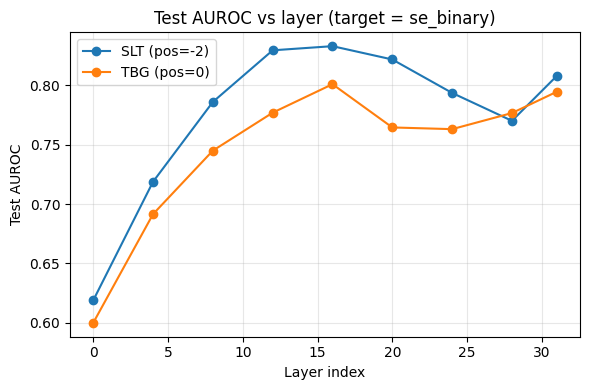

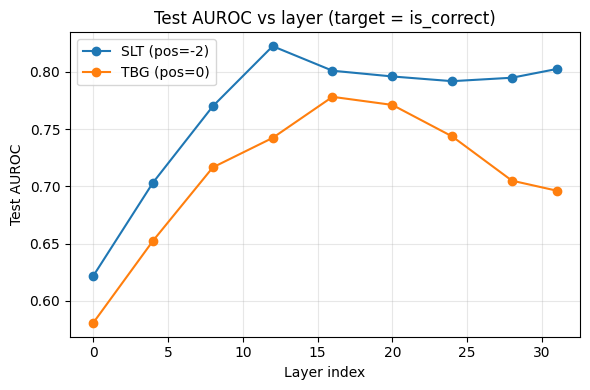

In [30]:
df = pd.DataFrame(all_results)

display(df.head())

def plot_auc_by_layer(df, target_field: str, title: str):
    df_t = df[df["target"] == target_field].copy()

    pos_labels = {0: "TBG (pos=0)", -2: "SLT (pos=-2)"}

    plt.figure(figsize=(6, 4))

    for pos in sorted(df_t["position"].unique()):
        sub = df_t[df_t["position"] == pos].sort_values("layer")
        plt.plot(
            sub["layer"],
            sub["test_auc"],
            marker="o",
            label=pos_labels.get(pos, f"pos={pos}"),
        )

    plt.xlabel("Layer index")
    plt.ylabel("Test AUROC")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_auc_by_layer(df, "se_binary", "Test AUROC vs layer (target = se_binary)")

plot_auc_by_layer(df, "is_correct", "Test AUROC vs layer (target = is_correct)")


Now we try to evaluate how well SEP predicts not SE labels but actualy is_correct labels. Is is target for SEP - detect hallutinations, we consider is_correct = 1 is no hallutination and is_correct = 0 is hallutination, so we try predict it. Infer models on test dataset and calculate AUC based on SEP predict.

In [31]:
def get_probe_predictions_on_test(all_models, test_data):
    """
    for each (target, pos, layer) return:
    - p_test: вероятности для test (N_test,)
    - y_test: истинные is_correct (N_test,)
    """
    results = {}

    for target, pos, layer in all_models.keys():
        clf = all_models[(target, pos, layer)]
        
        X_test, y_test, _ = build_Xy_from_dataset(
            test_data, position=pos, layer=layer, target_field="is_correct"
        )
        
        p_test = clf.predict_proba(X_test)[:, 1]  # P(class=1)
        
        if target == "se_binary":
            p_correct = 1.0 - p_test  # P(is_correct=1) = 1 - P(high_SE)
        else:  # is_correct probe
            p_correct = p_test

        results[(target, pos, layer)] = {
            "p_correct": p_correct,
            "y_test": y_test,
        }

    return results

probe_preds = get_probe_predictions_on_test(all_models, test_full)


In [32]:
auc_results = []

for (target, pos, layer), preds in probe_preds.items():
    p_correct = preds["p_correct"]
    y_test = preds["y_test"]
    
    auc = roc_auc_score(y_test, p_correct)
    
    auc_results.append({
        "target": target,
        "position": pos,
        "layer": layer,
        "test_auc_is_correct": auc,
    })

df_auc = pd.DataFrame(auc_results)
display(df_auc.head())


,target,position,layer,test_auc_is_correct
0,se_binary,0,0,0.568563
1,se_binary,0,4,0.630604
2,se_binary,0,8,0.679424
3,se_binary,0,12,0.708876
4,se_binary,0,16,0.723233


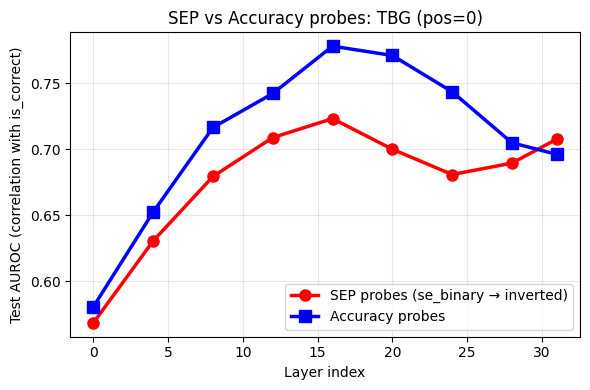

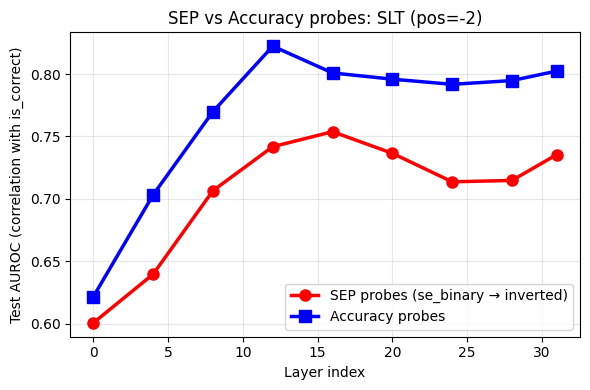

In [33]:
def plot_sep_vs_accuracy_auc(df_auc, position: int, title: str):
    df_pos = df_auc[df_auc["position"] == position].sort_values("layer")
    
    plt.figure(figsize=(6, 4))
    
    sep_df = df_pos[df_pos["target"] == "se_binary"]
    plt.plot(
        sep_df["layer"], sep_df["test_auc_is_correct"],
        marker="o", linewidth=2.5, markersize=8,
        label="SEP probes (se_binary → inverted)", color="red"
    )
    
    # Accuracy probes
    acc_df = df_pos[df_pos["target"] == "is_correct"]
    plt.plot(
        acc_df["layer"], acc_df["test_auc_is_correct"],
        marker="s", linewidth=2.5, markersize=8,
        label="Accuracy probes", color="blue"
    )
    
    plt.xlabel("Layer index")
    plt.ylabel("Test AUROC (correlation with is_correct)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for TBG (position=0)
plot_sep_vs_accuracy_auc(df_auc, position=0, title="SEP vs Accuracy probes: TBG (pos=0)")

# Plot for SLT (position=-2)
plot_sep_vs_accuracy_auc(df_auc, position=-2, title="SEP vs Accuracy probes: SLT (pos=-2)")


### 9.1 BONUS train SEP with weight experiment

In original paper was binarization. But there was not setting weight of sample. But it is loss of information. Here I tried not to lost information and when I have done binarization I also have made weight calculation with rules: if semantic entropy of sample is near threshold - it should get smaller weight near 0. If SE is near extremum we have weight near 2. For example, if we in class 1 (high entropy) and sample has SE near maximum, it gets weight near 2. Also normalization was made for weight expectation to be equal 1. So, if SE of some sample is near of mean it gets weight = 1. You can see exactly what was done in 6 step.

In [34]:
def compare_sep_weights_experiment(
    train_data,
    val_data,
    test_data,
    position: int,
    layers: list[int],
    k_folds: int = 5,
    seed: int = 42,
    max_iter: int = 500,
    C: float = 1.0,
    solver: str = "lbfgs",
    weight_field: str = "se_weight",
    metric_field: str = "test_auc",   # or "cv_auc_mean"
    verbose: bool = True,
):
    rows = []

    for layer in layers:
        # baseline: no weights
        _, m0 = train_and_eval_probe_cv(
            train_data, val_data, test_data,
            position=position,
            layer=layer,
            target_field="se_binary",
            k_folds=k_folds,
            seed=seed,
            max_iter=max_iter,
            C=C,
            solver=solver,
            use_weights=False,
            weight_field=weight_field,
        )
        rows.append({**m0, "use_weights": False})

        # weighted
        _, m1 = train_and_eval_probe_cv(
            train_data, val_data, test_data,
            position=position,
            layer=layer,
            target_field="se_binary",
            k_folds=k_folds,
            seed=seed,
            max_iter=max_iter,
            C=C,
            solver=solver,
            use_weights=True,
            weight_field=weight_field,
        )
        rows.append({**m1, "use_weights": True})

        if verbose:
            print(
                f"pos={position}, layer={layer}: "
                f"{metric_field} no_w={m0[metric_field]:.3f}, with_w={m1[metric_field]:.3f}"
            )

    df_cmp = pd.DataFrame(rows)

    # Plot
    plt.figure(figsize=(8, 5))
    for use_w, label in [(False, "No sample weights"), (True, "With se_weight")]:
        sub = df_cmp[df_cmp["use_weights"] == use_w].sort_values("layer")
        plt.plot(sub["layer"], sub[metric_field], marker="o", linewidth=2, label=label)

    plt.xlabel("Layer index")
    plt.ylabel(metric_field)
    plt.title(f"SEP probe quality vs layer (position={position}, target=se_binary)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_cmp


pos=0, layer=0: test_auc no_w=0.600, with_w=0.601
pos=0, layer=4: test_auc no_w=0.691, with_w=0.693
pos=0, layer=8: test_auc no_w=0.745, with_w=0.766
pos=0, layer=12: test_auc no_w=0.777, with_w=0.794
pos=0, layer=16: test_auc no_w=0.801, with_w=0.819
pos=0, layer=20: test_auc no_w=0.764, with_w=0.783
pos=0, layer=24: test_auc no_w=0.763, with_w=0.777
pos=0, layer=28: test_auc no_w=0.777, with_w=0.788
pos=0, layer=31: test_auc no_w=0.795, with_w=0.798


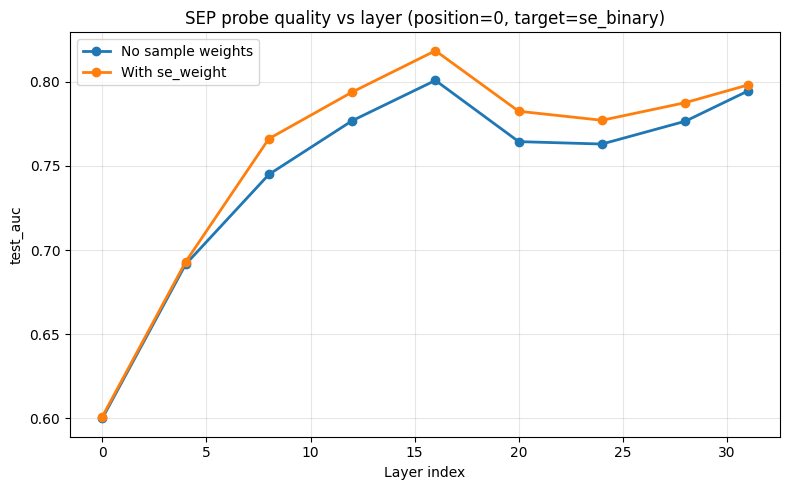

pos=-2, layer=0: test_auc no_w=0.619, with_w=0.615
pos=-2, layer=4: test_auc no_w=0.719, with_w=0.715
pos=-2, layer=8: test_auc no_w=0.786, with_w=0.794
pos=-2, layer=12: test_auc no_w=0.829, with_w=0.845
pos=-2, layer=16: test_auc no_w=0.833, with_w=0.855
pos=-2, layer=20: test_auc no_w=0.822, with_w=0.837
pos=-2, layer=24: test_auc no_w=0.794, with_w=0.809
pos=-2, layer=28: test_auc no_w=0.770, with_w=0.790
pos=-2, layer=31: test_auc no_w=0.808, with_w=0.814


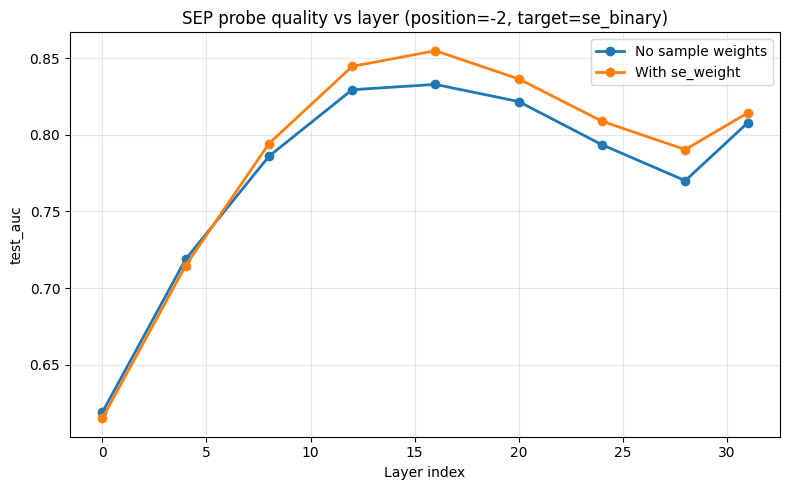

In [35]:
for pos in [0, -2]:
    # Example: compare on TBG (pos=0) or SLT (pos=-2)
    df_weights_cmp = compare_sep_weights_experiment(
        train_loaded, val_loaded, test_loaded,
        position=pos,                  # change to -2 if needed
        layers=layers_to_capture,    # or any list of layers
        k_folds=5,
        seed=SEED,
        max_iter=PROBE_MAX_ITER,
        C=PROBE_C,
        solver=PROBE_SOLVER,
        metric_field="test_auc",     # or "cv_auc_mean"
    )


### 10. Save models

In [36]:
# Create output directory
Path(OUTPUT_LINEAR_PROBES).mkdir(parents=True, exist_ok=True)

# Find best SE probe (from original training metrics)
best_se_idx = df[df["target"] == "se_binary"]["cv_auc_mean"].idxmax()
best_se_metrics = df.loc[best_se_idx].to_dict()
best_se_key = (best_se_metrics["target"], best_se_metrics["position"], best_se_metrics["layer"])
best_se_model = all_models[best_se_key]

print(f"Best SE probe: {best_se_key}, CV AUC: {best_se_metrics['cv_auc_mean']:.3f}")

# Find best Accuracy probe (from original training metrics)  
best_acc_idx = df[df["target"] == "is_correct"]["cv_auc_mean"].idxmax()
best_acc_metrics = df.loc[best_acc_idx].to_dict()
best_acc_key = (best_acc_metrics["target"], best_acc_metrics["position"], best_acc_metrics["layer"])
best_acc_model = all_models[best_acc_key]

print(f"Best Accuracy probe: {best_acc_key}, CV AUC: {best_acc_metrics['cv_auc_mean']:.3f}")

# Save SE probe model and metrics
se_probe_path = os.path.join(OUTPUT_LINEAR_PROBES, "se_probe.pkl")
with open(se_probe_path, "wb") as f:
    pickle.dump(best_se_model, f)

se_metrics_path = os.path.join(OUTPUT_LINEAR_PROBES, "se_probe_metrics.json")
with open(se_metrics_path, "w") as f:
    json.dump(best_se_metrics, f, indent=2)

# Save Accuracy probe model and metrics
acc_probe_path = os.path.join(OUTPUT_LINEAR_PROBES, "accuracy_probe.pkl")
with open(acc_probe_path, "wb") as f:
    pickle.dump(best_acc_model, f)

acc_metrics_path = os.path.join(OUTPUT_LINEAR_PROBES, "accuracy_probe_metrics.json")
with open(acc_metrics_path, "w") as f:
    json.dump(best_acc_metrics, f, indent=2)

print(f"Saved SE probe to {se_probe_path}")
print(f"Saved Accuracy probe to {acc_probe_path}")
print("Metrics saved as JSON files")


Best SE probe: ('se_binary', -2, 16), CV AUC: 0.845
Best Accuracy probe: ('is_correct', -2, 16), CV AUC: 0.833
Saved SE probe to ../models/probes/sep_demo/se_probe.pkl
Saved Accuracy probe to ../models/probes/sep_demo/accuracy_probe.pkl
Metrics saved as JSON files


### 11. Real scenario inference with linear probe

In [37]:
def real_inference(test_subset, probe, position, layer, probe_type="se"):
    """
    probe_type: "se" (SEP probe, invert predictions) or "accuracy" (direct P(correct))
    """
    results = []
    for i, ex in enumerate(test_subset):
        # 1. Generate greedy answer with activations
        gen_ex = process_one_example_greedy_with_acts(
            ex, model, tokenizer, system_prompt=SYSTEM_PROMPT
        )
        
        # 2. Extract activations for best position/layer
        acts = gen_ex["activations"]
        X_probe = acts["acts"][position][layer].cpu().numpy()
        X_probe = X_probe.reshape(1, -1)  # (1, hidden_dim)
        
        # 3. Predict with probe
        p_class1 = probe.predict_proba(X_probe)[:, 1][0]
        
        # 4. Convert to P(correct) and binary prediction
        if probe_type == "se":
            # SEP probe: P(high_SE) -> invert to P(correct)
            probe_pred_correct = 1.0 - p_class1
        else:
            # Accuracy probe: P(correct) directly
            probe_pred_correct = p_class1
        
        probe_pred_is_correct = probe_pred_correct > 0.5
        prediction_match = probe_pred_is_correct == gen_ex["is_correct"]
        
        # 5. Store results
        result = {
            "idx": i,
            "question": ex["question"],
            "gt_answers": ex["gt_answers"][:3],
            "generated_answer": gen_ex["greedy_answer"],
            "is_correct": gen_ex["is_correct"],
            "se_raw": ex["se_raw"],
            "se_binary": ex["se_binary"],
            "probe_pred": float(p_class1),
            "probe_pred_correct": float(probe_pred_correct),
            "probe_pred_is_correct": bool(probe_pred_is_correct),
            "prediction_match": bool(prediction_match),
            "sampling_answers": ex['sampling_answers'],
            "se_gamma": ex['se_gamma'],
        }
        results.append(result)

    # Display results
    for r in results:
        print(f"\n--- Example {r['idx']} ---")
        print(f"Q: {r['question']}")
        print(f"GT answers: {r['gt_answers']}")
        print(f"Generated: {r['generated_answer']}")
        print(f"True correct: {r['is_correct']}")
        print(f"True SE: {r['se_raw']:.3f} (binary: {r['se_binary']}), threshold: {r['se_gamma']:.3f}")
        print(f"Sampling answers: {r['sampling_answers'][:3]}{'...' if len(r['sampling_answers']) > 3 else ''}")
        print(f"Probe P(class=1): {r['probe_pred']:.3f} → P(correct): {r['probe_pred_correct']:.3f}")
        print(f"Probe prediction: {'correct' if r['probe_pred_is_correct'] else 'incorrect'}")
        print(f"Match: {'Yes' if r['prediction_match'] else 'No'}")

    # Accuracy summary
    accuracy = np.mean([r["prediction_match"] for r in results])
    print(f"\n--- Accuracy Summary ---")
    print(f"Probe accuracy: {accuracy:.1%} ({accuracy*len(results):.0f}/{len(results)})")
    
    return results


In [38]:
# Load SEP probe and metrics
with open(os.path.join(OUTPUT_LINEAR_PROBES, "se_probe.pkl"), "rb") as f:
    se_probe = pickle.load(f)

with open(os.path.join(OUTPUT_LINEAR_PROBES, "se_probe_metrics.json"), "r") as f:
    se_metrics = json.load(f)

# Extract position and layer for best SE probe
se_best_position = se_metrics["position"]
se_best_layer = se_metrics["layer"]

print(f"Loaded SEP probe: position={se_best_position}, layer={se_best_layer}")
print(f"Probe trained on {se_metrics['n_trainval']} trainval samples, CV AUC: {se_metrics['cv_auc_mean']:.3f}")

_ = real_inference(test_loaded[:10], se_probe, se_best_position, se_best_layer)

Loaded SEP probe: position=-2, layer=16
Probe trained on 3000 trainval samples, CV AUC: 0.845

--- Example 0 ---
Q: Who was the last British male to reach the final of a Grand Slam tennis singles tournament?
GT answers: ['greg ruzetsky', 'greg rudsedski', 'rusedski']
Generated: Andy Murray.
True correct: False
True SE: -0.000 (binary: 0), threshold: 0.742
Sampling answers: ['Andy Murray.', 'Murray.', 'Murray.']...
Probe P(class=1): 0.015 → P(correct): 0.985
Probe prediction: correct
Match: No

--- Example 1 ---
Q: Who was the last British athlete to compete in the Olympic 100 metres final?
GT answers: ['dwayne chambers', 'duaine chambers', 'dewayne chambers']
Generated: Usain Bolt.
True correct: False
True SE: 0.252 (binary: 0), threshold: 0.742
Sampling answers: ['Caleb Dressel.', 'Usain Bolt.', 'Usain Bolt']...
Probe P(class=1): 0.042 → P(correct): 0.958
Probe prediction: correct
Match: No

--- Example 2 ---
Q: Who bought the McDonalds fast food outlet business from the McDonald brot

In [39]:
# Load accuracy probe and metrics
with open(os.path.join(OUTPUT_LINEAR_PROBES, "accuracy_probe.pkl"), "rb") as f:
    accuracy_probe = pickle.load(f)

with open(os.path.join(OUTPUT_LINEAR_PROBES, "accuracy_probe_metrics.json"), "r") as f:
    accuracy_metrics = json.load(f)

# Extract position and layer for best SE probe
accuracy_best_position = accuracy_metrics["position"]
accuracy_best_layer = accuracy_metrics["layer"]

print(f"Loaded Accuracy probe: position={accuracy_best_position}, layer={accuracy_best_layer}")
print(f"Probe trained on {accuracy_metrics['n_trainval']} trainval samples, CV AUC: {accuracy_metrics['cv_auc_mean']:.3f}")

_ = real_inference(test_loaded[:10], accuracy_probe, accuracy_best_position, accuracy_best_layer, probe_type='accuracy')

Loaded Accuracy probe: position=-2, layer=16
Probe trained on 3000 trainval samples, CV AUC: 0.833

--- Example 0 ---
Q: Who was the last British male to reach the final of a Grand Slam tennis singles tournament?
GT answers: ['greg ruzetsky', 'greg rudsedski', 'rusedski']
Generated: Andy Murray.
True correct: False
True SE: -0.000 (binary: 0), threshold: 0.742
Sampling answers: ['Andy Murray.', 'Murray.', 'Murray.']...
Probe P(class=1): 0.305 → P(correct): 0.305
Probe prediction: incorrect
Match: Yes

--- Example 1 ---
Q: Who was the last British athlete to compete in the Olympic 100 metres final?
GT answers: ['dwayne chambers', 'duaine chambers', 'dewayne chambers']
Generated: Usain Bolt.
True correct: False
True SE: 0.252 (binary: 0), threshold: 0.742
Sampling answers: ['Caleb Dressel.', 'Usain Bolt.', 'Usain Bolt']...
Probe P(class=1): 0.041 → P(correct): 0.041
Probe prediction: incorrect
Match: Yes

--- Example 2 ---
Q: Who bought the McDonalds fast food outlet business from the Mc